In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    w = np.linalg.solve(np.transpose(tx).dot(tx), np.transpose(tx).dot(y))
    e = y - tx.dot(w)
    return w, np.sqrt(np.transpose(e).dot(e) / y.shape[0])

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [3]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    ls = least_squares(y, tx)
    print('w = ', ls[0], ', loss = ', ls[1])

Test it here

In [4]:
test_your_least_squares()

w =  [73.293922   13.47971243] , loss =  5.547231357863019


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.zeros((x.shape[0], degree + 1))
    for i in range(degree + 1) :
        for j in range(x.shape[0]) :
            poly[j, i] = x[j] ** i
    return poly
print(build_poly(np.array([1, 2, 3]), 2))

[[1. 1. 1.]
 [1. 2. 4.]
 [1. 3. 9.]]


Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [7]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        
        poly = build_poly(x, degree)
        
        weights, rmse = least_squares(y, poly)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773748
Processing 3th experiment, degree=7, rmse=0.24965870360907552
Processing 4th experiment, degree=12, rmse=0.24328247481248677


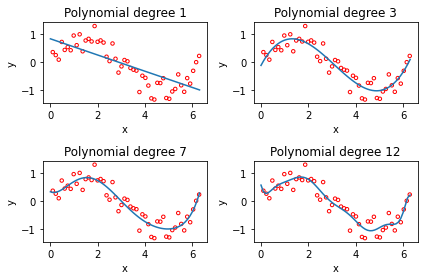

In [8]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [11]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)    
    random_pick = np.random.default_rng().choice(x.shape[0], int(x.shape[0]*ratio), replace=False)
    
    x_train = x[random_pick]
    y_train = y[random_pick]
    x_test = np.delete(x, random_pick)
    y_test = np.delete(y, random_pick)
    
    return x_train, y_train, x_test, y_test

Then, test your `split_data` function below.

In [12]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    
    poly_tr = build_poly(x_tr, degree)
    poly_te = build_poly(x_te, degree)
 
    w, rmse_tr = least_squares(y_tr, poly_tr)
    
    e_te = y_te - poly_te.dot(w)
    rmse_te = np.sqrt(np.transpose(e_te).dot(e_te) / y_te.shape[0])

    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [13]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.447, Testing RMSE=0.680
proportion=0.9, degree=3, Training RMSE=0.250, Testing RMSE=0.345
proportion=0.9, degree=7, Training RMSE=0.246, Testing RMSE=0.304
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.285
proportion=0.5, degree=1, Training RMSE=0.365, Testing RMSE=0.562
proportion=0.5, degree=3, Training RMSE=0.268, Testing RMSE=0.259
proportion=0.5, degree=7, Training RMSE=0.240, Testing RMSE=0.320
proportion=0.5, degree=12, Training RMSE=0.222, Testing RMSE=0.410
proportion=0.1, degree=1, Training RMSE=0.136, Testing RMSE=0.587
proportion=0.1, degree=3, Training RMSE=0.245, Testing RMSE=0.294
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=0.625
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=3.623


# 3 Ridge Regression
Please fill in the function below.

In [14]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    diag = np.identity(tx.shape[1]) * lambda_ * 2 * y.shape[0]
    
    w = np.linalg.solve(np.transpose(tx).dot(tx) + diag, np.transpose(tx).dot(y))
    e = y - tx.dot(w)
    return w, np.sqrt(np.transpose(e).dot(e) / y.shape[0])

In [15]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    
    poly_tr = build_poly(x_tr, degree)
    poly_te = build_poly(x_te, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        
        w, rmse_train = ridge_regression(y_tr, poly_tr, lambda_)
        e_te = y_te - poly_te.dot(w)
        rmse_test = np.sqrt(np.transpose(e_te).dot(e_te) / y_te.shape[0])
        
        rmse_tr.append(rmse_train)
        rmse_te.append(rmse_test)
        
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.261, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.261, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.261, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.261, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.261, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.261, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.261, Testing RMSE=0.268
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.261, Testing RMSE=0.267
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.261, Testing RMSE=0.267
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.263, Testing RMSE=0.267
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.267, Testing RMSE=0.271
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.279, Testing RMSE=0.287
proportion=0.5, degree=7, lambda=0.193, 

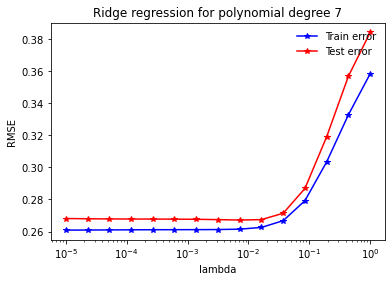

In [17]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)